## Simulation code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as rnd
from tqdm import tqdm

class DBM_RDG:

    def __init__(self,
                 N = 40,
                 dimensions=None,
                 nu=1.5,
                 debug=False,
                 threshold = 0.0001):

        # Unless specified, expect grid of NxNxN dimension, in order z, x, y
        if dimensions is None:
            self.dim = {'height': N, 'width': N,'depth': N}
        else:
            self.dim = {'height': dimensions[0], 'width': dimensions[1],'depth': dimensions[2]}

        # Create encoding grid and set all to 0
        #  0 encodes unfixed potential
        #  anything else encodes fixed potential
        # (I also use this grid to track order of cells in lightning structure)
        self.fixed_grid = np.zeros(shape=list(self.dim.values()))
        
        # Set all boundaries to be fixed
        self.fixed_grid[:, :, 0] = -1  # front boundary
        self.fixed_grid[:, :, -1] = -1  # back boundary
        self.fixed_grid[:, 0, :] = -1  # left boundary
        self.fixed_grid[:, -1, :] = -1  # right boundary
        self.fixed_grid[0, :, :] = -1  # top boundary
        self.fixed_grid[-1, :, :] = -1  # bottom boundary

        # The electric potential
        self.potential = np.zeros(shape=list(self.dim.values()))

        # The lightning downwards-tendency parameter
        self.nu = nu

        # Number of update steps
        self.steps = 1

        # To debug or not
        self.debug = debug

        # Keep track of current neighbors of structure
        self.structure_neighbors = set()

        self.struck_ground = False

        self.threshold = threshold

        # Debugging lists
        self.difference_per_conv = []
        self.overall_sum = []
        
        self.structure_history = []
        
        self.dist_to_ground = self.dim['depth']

        # odd neighbors
        self.odd_neighbors = [(1, 0, 0), (0, 1, 0), (-1, 0, 0), (0,-1, 0), (0, 0, 1), (0, 0, -1),  
                          (0, 1, 1), 
                          (0, 1, -1), 
                          (1, 1, 1), 
                          (1, 1, -1), 
                          (1, 0, -1), 
                          (1, 0, 1) 
                         ]
        
        
        # Even neighbors
        self.even_neighbors = [(1, 0, 0), (0, 1, 0), (-1, 0, 0), (0,-1, 0), (0, 0, 1), (0, 0, -1),  
                          (0, -1, 1), 
                          (0, -1, -1), 
                          (-1, -1, 1), 
                          (-1, -1, -1),
                          (-1, 0, -1),
                          (-1, 0, 1) 
                         ]
        
        # Setup initial electric potential
        self.initial_electric_pot()

        # Add the first cell as a structure neighbor
        self.structure_neighbors.add((self.dim['height']//2, self.dim['width']//2, 0))

        # Update structure with that cell
        self.expand_lightning_to((self.dim['height']//2, self.dim['width']//2, 0))

        
        self.steps += 1
               
    # Could remove this
    def get_neighbors(self, pos):
        '''Returns the set of neighbors given cell position'''
        
        neighbors = []
        
        # Cell neighbors list alternate each layer in z-axis
        if pos[2] % 2 == 0:
            for neighbor_rel in self.even_neighbors:
                neighbors.append((pos[0]+neighbor_rel[0], pos[1]+neighbor_rel[1], pos[2]+neighbor_rel[2]))
        else:
            for neighbor_rel in self.odd_neighbors:
                neighbors.append((pos[0]+neighbor_rel[0], pos[1]+neighbor_rel[1], pos[2]+neighbor_rel[2]))

        return neighbors


    def strike_lightning(self):
        '''Run simulation until structures strikes ground'''

        # Run update until lightning strikes ground
        self.struck_ground = False

        # Create a tqdm tracker
        if self.debug:
            progress_bar = tqdm(total=self.dim['depth'], desc="How close the lightning is to the ground", unit="iter")

        while not self.struck_ground:
            # Update lightning
            self.update()

            if self.debug:
                # If the newly added cell made the lightning stretch one step lower, update dist_to_ground
                if self.dim['depth'] - self.newest_neighbor[2] < self.dist_to_ground:
                    self.dist_to_ground = self.dim['depth'] - self.newest_neighbor[2]
                    progress_bar.update(1)

    def update(self):
        '''Choose structure neighbor to expand into, update electric potential'''

        weights = []
        # For each structure neighbor
        for neighbor_pos in self.structure_neighbors:
            # Raise each weight to the power of nu
            weights.append(self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] ** self.nu)
        
        # Choose a random neighbor with the weighting
        chosen_cell = rnd.choices(list(self.structure_neighbors), weights)[0]

        # Update lightning grid, potential and newest neighbor
        self.expand_lightning_to(chosen_cell)

        self.steps += 1

    def initial_electric_pot(self):
        # Create a linear gradient along the depth axis
        gradient = np.linspace(0, 1, self.dim['depth'])[np.newaxis, np.newaxis, :]
        #gradient = np.linspace(0, 0, self.dim['height'])[:, np.newaxis, np.newaxis]

        # Apply the gradient to the array
        self.potential += gradient


    def expand_lightning_to(self, pos):
        '''
        Updates correpsonding grids
        Update neighborhood of lightning structure
        Call method to update electric potential
        '''

        self.newest_neighbor = pos
        
        self.structure_history.append(pos)

        # Remove the potential
        self.potential[pos[0], pos[1], pos[2]] = 0
        #self.potential[pos[0], pos[1], pos[2]] = 1

        # Set it as a fixed cell
        self.fixed_grid[pos[0], pos[1], pos[2]] = self.steps

        # Update structure neighbors
        self.structure_neighbors.remove(pos)
        for neighbor_pos in self.get_neighbors(pos):
            if neighbor_pos[2] == self.dim['depth']:
                self.struck_ground = True
                break

            if neighbor_pos[0] >= 0 and neighbor_pos[0] < self.dim['height'] and \
                neighbor_pos[1] >= 0 and neighbor_pos[1] < self.dim['width'] and \
                neighbor_pos[2] >= 0 and neighbor_pos[2] < self.dim['depth'] and \
                self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] != 0:
                    self.structure_neighbors.add(neighbor_pos)

        if not self.struck_ground:
            # Update the rest of the potential
            self.potential = self.update_electric_potential()


    def update_electric_potential(self):
        '''
        Uses iterative diffusion to estimate solution to Laplace equation.
        Tracks percentual change for each cell after each diffusion, 
        terminates when the largest percentual change is less than threshold
        '''

        # Make ground and lightning structure fixed
        no_change_mask = self.fixed_grid != 0


        old_potential = np.copy(self.potential)
        new_potential = np.copy(old_potential)

        itr = 0
        # Until threshold is hit, keep updating electric potential
        while True:
            
            # Two arrays for the two types of neighborhoods
            neighbor_avgs_even_new = np.zeros_like(new_potential)
            neighbor_avgs_odd_new = np.zeros_like(new_potential)
            
            # Perform diffusion globally using both neighbors
            for neighbor in self.odd_neighbors:
                neighbor_avgs_odd_new += np.roll(new_potential, neighbor, axis=(0,1,2))
                
            for neighbor in self.even_neighbors:
                neighbor_avgs_even_new += np.roll(new_potential, neighbor, axis=(0,1,2))
                
            # Set odd z-axis layers to 0
            neighbor_avgs_odd_new[:,:,1::2] = 0
            # Set even z-axis layers to 0
            neighbor_avgs_even_new[:,:,::2] = 0
            
            # Merge them
            neighbor_avgs_new = (neighbor_avgs_even_new + neighbor_avgs_odd_new) / len(self.even_neighbors)
        
            new_potential = neighbor_avgs_new
        
            # Reset the cells that shouldn't change
            new_potential[no_change_mask] = self.potential[no_change_mask]
        
            if self.debug:
                self.difference_per_conv.append(np.sum(abs(np.array(new_potential) - np.array(old_potential))))
                self.overall_sum.append(np.sum(np.array(new_potential)))
            
            # percentual change relative to previous iteration
            rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)

            # Terminate when max percentual change is small (below threshold)
            if np.nanmax(rel_differences) < self.threshold:
                break

            old_potential = np.copy(new_potential)
            
        return new_potential

### Analyse time to run

In [2]:
import cProfile
width=20
height=20
nu=6
threshold=0.001
sim_instance = DBM_RDG(dimensions=(width, width, height), nu=nu, threshold=threshold)
cProfile.run("sim_instance.strike_lightning()")

C:\Users\gabri\AppData\Local\Temp/ipykernel_31468/3269852316.py:315: RuntimeWarning: invalid value encountered in divide
  rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)


         187498 function calls in 0.615 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       26    0.000    0.000    0.000    0.000 3269852316.py:123(get_neighbors)
        1    0.000    0.000    0.615    0.615 3269852316.py:162(strike_lightning)
       26    0.002    0.000    0.615    0.024 3269852316.py:181(update)
       26    0.001    0.000    0.612    0.024 3269852316.py:206(expand_lightning_to)
       25    0.156    0.006    0.611    0.024 3269852316.py:242(update_electric_potential)
        1    0.000    0.000    0.615    0.615 <string>:1(<module>)
      641    0.001    0.000    0.004    0.000 _methods.py:55(_any)
      666    0.000    0.000    0.000    0.000 function_base.py:869(_copy_dispatcher)
      666    0.001    0.000    0.004    0.000 function_base.py:873(copy)
     1282    0.000    0.000    0.000    0.000 multiarray.py:1080(copyto)
    16666    0.002    0.000    0.002    0.000 multiarray.py:85(empty_like)


## Gather data

In [1]:
# --- Simulation parameters ---
N=70
width = int(N*1.5)
height = N
nu=6
threshold=0.001
# -----------------------------

filename_viz = f"C:\\Users\\gabri\\Desktop\\Capstone\\data\\RDG_square_int\\{width}x{width}x{height}_{nu}_{threshold}_vizdata.txt"
filename_strike = f"C:\\Users\\gabri\\Desktop\\Capstone\\data\\RDG_square_int\\{width}x{width}x{height}_{nu}_{threshold}_strikedata.txt"
filename_volume = f"C:\\Users\\gabri\\Desktop\\Capstone\\data\\RDG_square_int\\{width}x{width}x{height}_{nu}_{threshold}_volumedata.txt"
viz_file = open(filename_viz,'a')
strike_file = open(filename_strike,'a')
volume_file = open(filename_volume,'a')

viz_storing_freq = 100

i = 0
while True:
    sim_instance = DBM_RDG(dimensions=(width, width, height), nu=nu, threshold=threshold)
    sim_instance.strike_lightning()

    i += 1

    if i % viz_storing_freq == 0:
        for pos in sim_instance.structure_history:
            viz_file.write(f"{pos}.")
        viz_file.write('#')
        print()

    strike_file.write(f"{sim_instance.newest_neighbor}#")
    volume_file.write(f"{len(sim_instance.structure_history)}#")
    
    print('*', end='')


In [11]:
viz_file.close()
strike_file.close()
volume_file.close()

## Strike location distribution

Datapoints: 1516


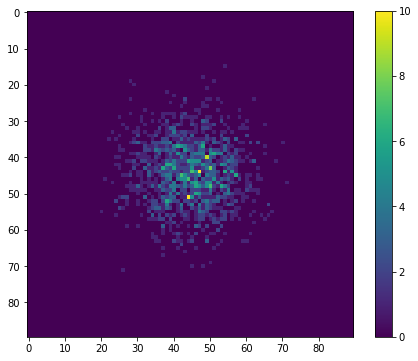

In [9]:
N=60
width=int(N*1.5)
height=N
nu=6
threshold=0.001

filename_strike = f"C:\\Users\\gabri\\Desktop\\Capstone\\data\\RDG_square_int\\{width}x{width}x{height}_{nu}_{threshold}_strikedata.txt"
strike_file = open(filename_strike,'r')
strike_data_str = strike_file.read()
strike_data_str = strike_data_str.split('#')[:-1]

strike_data = np.zeros((width, width))
print("Datapoints:",len(strike_data_str))

for point in strike_data_str:
    point = point.split(',')
    x_coord = point[0]
    y_coord = point[1]
    x_coord = x_coord.strip()
    x_coord = x_coord.strip('(')
    y_coord = y_coord.strip()
    y_coord = y_coord.strip(')')
    strike_data[int(x_coord), int(y_coord)] += 1

cmap = matplotlib.cm.viridis
fig = plt.figure(figsize=(8,6))
plt.imshow(strike_data, cmap=cmap)
plt.colorbar()
plt.show()